# Introduction

This project was inspired by the paper [Deep Learning for Symbolic Mathematics](https://arxiv.org/abs/1912.01412?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529) by G. Lample and F. Charton. The authors apply a seq2seq transformer model to solve inverse problems in symbolic mathematics, namely the integration of functions in one variable and the solving of first and second order ordinary differential equations.

I wanted to see if a transformer would also be successful in factoring polynomials with integer coefficients. Although a deterministic polynomial-time algorithm is known (the 1982 LLL algorithm of Lenstra, Lenstra and Lovasz), it does not perform well in practice. For that reason computer algebra systems such as Mathematica and Maple resort to probabilistic algorithms that perform better on average. It thus seemed appropriate to try to find out how well would a deterministic neural network perform on that task.

To limit the scope of the problem, only polynomials with degree at most 8 and with coefficients in the range [-5, 5] were considered. It is also required that such a polynomial be primitive, that is the gcd of its coefficients is 1. This represents a space of some 2B possible polynomials.

# Formulation of the problem

We consider the space Z[x] of polynomials with integer coefficients, e.g. 1 + 2x + x^2. A polynomial p(x) in Z[x] is called irreducible if no non-constant polynomial other than itself into it. On the other hand a polynomial is called a primitive if the gcd of its coefficients is 1. So for example 1 + 3x^2 is irreducible but 2 + 8x^3 is not.

A primitive polynomial can always be expressed as a product of uniuely determined primitive irreducible polynomials. For example, the primitive polynomial -1 - 2x - x^2 + 3x^4 - 2x^5 - x^6 + 4x^7 can be expressed as the product of the primitive polynomials 

(1 + 2x + 2x^2 + 2x^3 - x^4 + 4x^5)(1 + x)(-1 + x) 

More generally, we can always factor out the gcd of the coefficients of a polynomial so that the condition of primitivity is met, so the general problem of factoring polynomials in Z[x] reduces to that of factoring primitive polynomials. Within the general project of applying neural networks to symbolic mathematics, I wish to explore how effective would a neural network be in learning to decompose polynomials into their irreducible factors.

# Running the experiment

We will train a seq2seq transformer model on 20M examples of primitive polynomials of degree at most 8 and with coefficients in the range [-5, 5]. The examples were all generated in Mathematica.

In [1]:
import pickle as pk
import numpy as np
from random import shuffle
import keras
import copy
from keras_transformer import get_model, get_custom_objects

Let's load the training data. It is stored in four seperate files. The training data will consist in two lists: one containing polynomials and the other their decompositions. Polynomials are store as numpy arrays of shape (9,) and decompositions as numpy arrays of shape (9n,) where n is the number of irreducible factors. For example, the polynomial -1 - 2x - x^2 + 3x^4 - 2x^5 - x^6 + 4x^7 we saw above is stored as the array 

[-1, -2, -1, 0, 3, -2, -1, 4, 0] 

and its decomposition (1 + 2x + 2x^2 + 2x^3 - x^4 + 4x^5)(1 + x)(-1 + x) 
is stored as the array 

[1, 2, 2, 2, -1, 4, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0]. 

By convention, the irreducible factors are listed in reverse lexicographical order. To recover the individual factors from a (9n,)-shaped array storing a decomposition we need to split it into n equal parts.

In [2]:
for i in range(1, 5):
  with open('polys_int_set_{}.pkl'.format(i), 'rb') as file:
    globals()['polys_%s' % i], _ = pk.load(file)

  with open('decomp_int_set_{}.pkl'.format(i), 'rb') as file:
    globals()['decomps_%s' % i], _ = pk.load(file)

polys = polys_1 + polys_2 + polys_3 + polys_4
decomps = decomps_1 + decomps_2 + decomps_3 + decomps_4

for i in range(1, 5):
  del  globals()['polys_%s' % i]
  del  globals()['decomps_%s' % i]

Let's get a visual on some attributes of the data.

In [3]:
num_factors = []
degrees = []

for poly in polys:
  degree = len(np.trim_zeros(poly, 'b')) - 1
  degrees.append(degree)

for decomp in decomps:
  splits = len(decomp) / 9
  num_factors.append(splits)

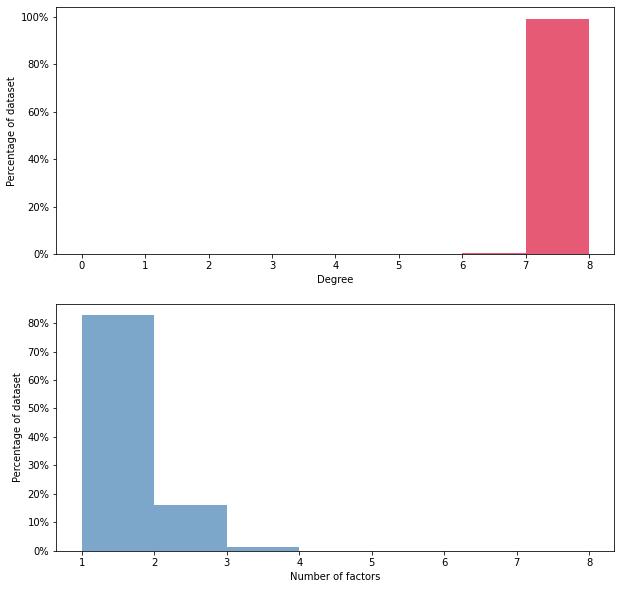

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1)
ax[0].hist(degrees, density=True, bins=range(9), alpha=0.7, color='crimson')
ax[1].hist(num_factors, density=True, bins=range(1,9), alpha=0.7, 
           color='steelblue')
ax[0].set(xlabel='Degree', ylabel='Percentage of dataset')
ax[1].set(xlabel='Number of factors', ylabel='Percentage of dataset')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
fig.set_size_inches(10, 10)
fig.show()

More than 90% of the polynomials in the dataset have degree 8. This is what we'd expect since there are about 11 times more polynomials of degree 8 than polynomials of degree 7 for the restricted range of coefficients [-5, 5]. On the other hand over 80% of the polynomials in the dataset are irreducible, i.e. their decompositions consist of those polynomials themselves. So we will only consider the experiment a success if we can achieve an accuracy much higher than 80%.

In [5]:
def to_string(poly):
  poly = poly.astype('int')
  poly = [str(number) for number in poly]
  string_poly = [""] * (2*len(poly) - 1)
  string_poly[0::2] = poly
  string_poly[1::2] = '+'*(len(poly) - 1) 
  return ''.join(string_poly)

def to_int_array(poly):
  poly = poly.split('+')
  poly = np.asarray([int(number) for number in poly])
  return np.trim_zeros(poly, 'b')

In [6]:
for index, poly in enumerate(polys):
  poly = to_string(poly)
  polys[index] = poly

for index, de in enumerate(decomps):
  splits = int(len(de) / 9)
  factors = np.split(de, splits)
  factors = [np.trim_zeros(factor, 'b') for factor in factors]
  factors = [to_string(factor) for factor in factors]
  string_factors = [""]*(2*splits - 1)
  string_factors[0::2] = factors
  string_factors[1::2] = '|'*(splits - 1)
  string_factors = ''.join(string_factors)
  decomps[index] = string_factors

Now we prepare the training data for training. We will encode the data character by character, treating + and - as label classes. We need to be careful about memory management due to the large size of the data and the 24GB cap of usable RAM in Google Collab pro.

Recall that during training seq2seq models require two inputs: the input to the encoder layer, in this case the polynomials we wish to decompose, and the input to the decoder layer which is the target output shifted one timestep into the past. The idea is to train the model to make a prediction for timestep t having seen timesteps 1...t.

In [7]:
# Define dictionary for encoding
token_dict = {}
token_dict['pad'] = 0
for i in (list(range(0, 10)) + ['+', '-', '|', 'start', 'end']):
  token_dict[str(i)] = len(token_dict)
rev_token_dict = {v:k for k, v in token_dict.items()}

In [8]:
# determine maximum input and output lengths
max_len_decomps = 0
for de in decomps:
  if len(de) > max_len_decomps:
    max_len_decomps = len(de)

max_len_polys = 0
for poly in polys:
  if len(poly) > max_len_polys:
    max_len_polys = len(poly)

In [9]:
data_len = len(polys)

encoder_inputs = np.zeros((data_len, max_len_polys + 2))
decoder_inputs = np.zeros((data_len, max_len_decomps + 2))
decoder_outputs = np.zeros((data_len, max_len_decomps + 2))

for index in range(data_len):
  posn = data_len - index - 1

  # construct encoder input
  poly = polys.pop()
  poly = np.asarray([token_dict[char] for char in poly] + 
                    [token_dict['end']], 'int')
  poly = np.pad(poly, (1, max_len_polys + 1 - len(poly)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  encoder_inputs[posn, :] = poly

  # construct decoder input and output

  # first preprocess decomposition
  de = decomps.pop()
  de = np.asarray([token_dict[char] for char in de] + 
                  [token_dict['end']], 'int')
  de_1 = np.pad(de, (1, max_len_decomps + 1 - len(de)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  de_2 = np.pad(de, (0, max_len_decomps + 2 - len(de)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  decoder_inputs[posn, :] = de_1
  decoder_outputs[posn, :] = de_2

Now we construct model. Hyperparameters were chosen based on standard values suggested in the literature. This is because each training iteration takes several hours and thus hyperparameter-tuning would be prohibitively time-consuming.

In [10]:
model = get_model(
    token_num=len(token_dict),
    embed_dim=512,
    encoder_num=6,
    decoder_num=6,
    head_num=8,
    hidden_dim=2048,
    attention_activation='relu',
    feed_forward_activation='relu')
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Token-Embedding (EmbeddingRet)  [(None, None, 512),  8192        Encoder-Input[0][0]              
                                                                 Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 512)    0           Token-Embedding[0][0]        

The model is trained for just 1 epoch, which takes 10h on Google Collab Pro.

In [11]:
model.fit(
    x=[encoder_inputs, decoder_inputs],
    y=decoder_outputs,
    epochs=1,
    batch_size=256)

77344/77344 [==============================] - 20619s 266ms/step - loss: 0.1223 - accuracy: 0.9348


In [12]:
del encoder_inputs, decoder_inputs, decoder_ouputs
model.save('./model_1')

Next, test data is loaded and processed.

# Testing

Let's see how will our trained neural network does on never-seen data. We load the test data and preprocess it like before.

In [13]:
for i in range(1, 5):
  with open('polys_int_set_{}.pkl'.format(i), 'rb') as file:
    _, globals()['test_polys_%s' % i] = pk.load(file)

  with open('decomp_int_set_{}.pkl'.format(i), 'rb') as file:
    _, globals()['test_decomps_%s' % i] = pk.load(file)

test_polys = test_polys_1 + test_polys_2 + test_polys_3 + test_polys_4
test_decomps = test_decomps_1 + test_decomps_2 + test_decomps_3 + test_decomps_4
for i in range(1, 5):
  del  globals()['test_polys_%s' % i]
  del  globals()['test_decomps_%s' % i]

In [14]:
for index, poly in enumerate(test_polys):
  poly = to_string(poly)
  test_polys[index] = poly

for index, de in enumerate(test_decomps):
  splits = int(len(de) / 9)
  factors = np.split(de, splits)
  factors = [np.trim_zeros(factor, 'b') for factor in factors]
  factors = [to_string(factor) for factor in factors]
  string_factors = [""]*(2*splits - 1)
  string_factors[0::2] = factors
  string_factors[1::2] = '|'*(splits - 1)
  string_factors = ''.join(string_factors)
  test_decomps[index] = string_factors

Let's just make sure that the maximal lengths of our test data does not exceed those seen in the training set.

In [15]:
max_len_polys_test = 0
for poly in test_polys:
  if len(poly) > max_len_polys_test:
    max_len_polys_test = len(poly)

max_len_decomps_test = 0
for de in test_decomps:
  if len(de) > max_len_decomps_test:
    max_len_decomps_test = len(de)

assert max_len_polys >= max_len_polys_test
assert max_len_decomps >= max_len_decomps_test

Let's prepare the test data like we did for the training data.


In [16]:
data_len = len(test_polys)

test_encoder_inputs = np.zeros((data_len, max_len_polys + 2))
test_decoder_inputs = np.zeros((data_len, max_len_decomps + 2))
test_decoder_outputs = np.zeros((data_len, max_len_decomps + 2))

for index in range(data_len):
  posn = data_len - index - 1

  # construct encoder input
  poly = test_polys.pop()
  poly = np.asarray([token_dict[char] for char in poly] + 
                    [token_dict['end']], 'int')
  poly = np.pad(poly, (1, max_len_polys + 1 - len(poly)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  test_encoder_inputs[posn, :] = poly

  # construct decoder input and output

  # first preprocess decomposition
  de = test_decomps.pop()
  de = np.asarray([token_dict[char] for char in de] + 
                  [token_dict['end']], 'int')
  de_1 = np.pad(de, (1, max_len_decomps + 1 - len(de)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  de_2 = np.pad(de, (0, max_len_decomps + 2 - len(de)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  test_decoder_inputs[posn, :] = de_1
  test_decoder_outputs[posn, :] = de_2


del test_polys, test_decomps

First we test our neural network in the same way we trained it.

In [17]:
model.evaluate([test_encoder_inputs, test_decoder_inputs], test_decoder_outputs)

6250/6250 [==============================] - 98s 16ms/step - loss: 0.0050 - accuracy: 0.9981


[0.004966276697814465, 0.9981300234794617]

Not bad! Next we will test our model at inference, i.e. without any knowledge of the correct decoder inputs. We will do this with beam search.

In [18]:
def beam_search(model, src_input, k=1, max_len=max_len_decomps + 2):
    # k_beam will be updated to contain best k beams at each timestep
    src_input = src_input.reshape((1,max_len_polys + 2))
    k_beam = [(0, np.zeros(max_len))]

    # l : point on target sentence to predict
    for l in range(max_len):
        all_k_beams = []
        for prob, sent_predict in k_beam:
          if token_dict['end'] in sent_predict:
            all_k_beams.append((prob, sent_predict))
          else:
            decoder_input = np.concatenate([[token_dict['start']], 
                                          sent_predict[:-1]]).reshape(
                                              (1,max_len))
            predicted = model.predict([src_input, decoder_input])[0]
            possible_k = predicted[l].argsort()[-k:][::-1]
      
            for next_wid in possible_k:
              all_k_beams.append(
                  (prob - np.log(predicted[l][next_wid]), np.concatenate(
                      [sent_predict[:l], np.asarray([next_wid]), np.zeros(
                         max_len - l - 1)])))
        k_beam = sorted(all_k_beams, key=lambda tup:tup[0])[:k]

    return k_beam

We test the accuracy of the model using different beam sizes at inference on 1000 test inputs. We consider the neural network as having solved a problem if the solution in the final beam.


In [19]:
tests = list(zip(test_encoder_inputs, test_decoder_outputs))
shuffle(tests)
test_encoder_inputs, test_decoder_outputs = zip(*tests)
test_encoder_inputs = list(test_encoder_inputs[:1000])
test_decoder_outputs = list(test_decoder_outputs[:1000])

In [20]:
for k in [1, 2, 3, 5, 10]:
  truth_list = []
  for index, poly in enumerate(test_encoder_inputs):
    for _, soln in beam_search(model=model, src_input=poly, k=k):
      if np.array_equal(test_decoder_outputs[index], soln):
        truth_list.append(True)
        break
    if len(truth_list) < index + 1:
      truth_list.append(False)
  print('Accuracy with beam size {}:'.format(k),
        '{}/{}'.format(truth_list.count(True), len(test_encoder_inputs)))

Accuracy with beam size 1: 983/1000
Accuracy with beam size 2: 987/1000
Accuracy with beam size 3: 991/1000
Accuracy with beam size 5: 992/1000
Accuracy with beam size 10: 993/1000


Accuracy steadily improved with beam size. This is in contrast to NLP applications where increased beam size can sometimes be detrimental to accuracy. Lample and Charton also observed substantial improvements as beam size increased. This suggests that for purpose of symbolic mathematics, higher beam size is generally better.

Finally, I wanted to see how well would the model generalize to a range of input characters it has never seen. For that purpose we generate a set of 100 polynomials with coefficients between -9 and 9, making sure that not all coefficients are between -5 and 5. 

In [21]:
from math import gcd
from random import choices

def gcd_v(array):
  array = array.astype('int')
  if len(array) == 2:
    return gcd(array[0], array[1])
  return gcd(gcd_v(array[:-1]), array[-1])

new_polys = []

while len(new_polys) < 100:
  poly = choices(range(-9, 10), k=9)
  if max(poly) <= 5 and min(poly) >= -5:
    continue
  else:
    poly = np.asarray(poly, 'int')
    poly = poly / gcd_v(poly)
    new_polys.append(poly)

# preprocess for feeding to neural network
for index, poly in enumerate(new_polys):
  poly = to_string(poly)
  assert len(poly) <= max_len_polys # may have to run cell more than once
  new_polys[index] = poly

new_polys_inputs = np.zeros((len(new_polys), max_len_polys + 2))

for index, poly in enumerate(new_polys):
  posn = len(new_polys) - index - 1
  poly = np.asarray([token_dict[char] for char in poly] + 
                    [token_dict['end']], 'int')
  poly = np.pad(poly, (1, max_len_polys + 1 - len(poly)), 'constant', 
                constant_values=(token_dict['start'], token_dict['pad']))
  new_polys_inputs[posn, :] = poly

We will simply check whether the neural network's solutions are 1. valid and 2. give factors that multiply to the input polynomials, nevermind the irreducibility of the factors. Let's define a function verify_soln() for that purpose.

In [22]:
def polymul(p1, p2):
  prod_size = len(p1) + len(p2) - 1
  p1 = np.pad(p1, (0, prod_size - len(p1)))
  p2 = np.pad(p2, (0, prod_size - len(p2)))
  prod = np.zeros(prod_size)
  for k in range(prod_size):
    for j in range(k + 1):
      prod[k] += p1[j] * p2[k - j]
  prod = np.trim_zeros(prod, 'b')
  return prod

def is_valid(string_poly):
  digits = [str(i) for i in range(0,10)]
  if string_poly[-1] not in digits:
    return False
  elif "--" in string_poly or "++" in string_poly or "-+" in string_poly:
    return False
  else:
    return True

def verify_soln(poly, soln):
  # preprocess polynomial
  poly = np.trim_zeros(poly, 'b')[1:-1]
  poly = poly.tolist()
  poly = ''.join([rev_token_dict[member] for member in poly])
  poly = to_int_array(poly)

  # preprocess solution
  soln = np.trim_zeros(soln, 'b')
  if soln[-1] != token_dict['end']:
    return False
  soln = soln[:-1].tolist()
  soln = ''.join([rev_token_dict[member] for member in soln])
  factors = soln.split('|')
  validity = [is_valid(factor) for factor in factors]
  if False in validity:
    return False
  factors = [to_int_array(factor) for factor in factors]

  product = np.ones(1)
  while len(factors) > 0:
    factor = factors.pop()
    product = polymul(product, factor)

  if np.array_equal(poly, product):
    return True
  else:
    return False

Let's try with beam sizes 1, 3 and 5.

In [23]:
for k in [1, 3, 5]:
  truth_list = []
  for index, poly in enumerate(new_polys_inputs):
    for _, soln in beam_search(model=model, src_input=poly, k=k):
      if verify_soln(poly, soln):
        truth_list.append(True)
        break
    if len(truth_list) < index + 1:
      truth_list.append(False)
  print('Accuracy with beam size {}:'.format(k),
        '{}/{}'.format(truth_list.count(True), len(new_polys_inputs)))

Accuracy with beam size 1: 0/100
Accuracy with beam size 3: 0/100
Accuracy with beam size 5: 0/100


The neural network doesn't generalize at all! This is not too surprising; the embedding layer does not actually "understand" numerical quantities and so there is no reason it should generalize to a range of input coefficients it has never seen. This said, there is a caveat: the model would have a better chance at generalization if had seen every digit and positional value at least once, as opposed to only seeing the digits 0-5 and their negative. For instance, it might be able to correctly interpret the number 15 if it sees 10 and 5 during training. However, naively extending the range of input coefficients to [-10, 10] would require a larger training dataset since the input space would be far larger (about 700B possible inputs). I expect that by adding a neural arithmetic logic unit (see [Neural Arithmetic Logic Units](https://arxiv.org/abs/1808.00508)) to the model we would see significant improvements to never-seen ranges.

# Conclusions

Athough the neural network performed well on test data drawn from the input coefficient range on which it was trained, it completely failed to generalize to test data drawn from a never-seen coefficient range. It appears to me the issue is that a naive transformer model is not sufficient: we need layers that provide the neural network with a "sense" of numeracy. NALUs seem promising in that regard. Furthermore it seems that without such improvements to the transformer model, datasets would need to be extremely large to obtain adequate accuracy over an acceptably large input space.

Nonetheless, the fact that the neural network displayed such great accuracy on the restricted input space we considered, this after having seen less than 1% of all possible inputs, is very promising. It swhows that neural networks are indeed capable of learning non-trivial mathematical relationships exceptionally well. I therefore expect them to continue finding applications in symbolic mathematics, even though they are not the panacea they may appear to be at first glance. I am very interested in exploring ways of improving the transformer model for this special use case in the future.